In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv
/kaggle/input/full-filled-brain-stroke-dataset/full_data.csv
/kaggle/input/full-filled-brain-stroke-dataset/full_filled_stroke_data (1).csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt;
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error

## Today I will implement very obsessively handlig to missing values.
![](https://www.indiewire.com/wp-content/uploads/2018/03/stanley-kubricks-the-shining-at-universals-halloween-horror-nights-2017.jpg)

In [3]:
df=pd.read_csv("../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
# id column is just unique values drop it
df.drop(columns="id",inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Here we have 201 missed bmi values. (3.93%)

## Preprocessing

In [5]:
# Most common method for handling miss values is filling miss value with column mean, median or mod.
# But here we will handling BMI columns as a target column and making regression analysis.
# This dataset is perfect for this solution.

In [6]:
print("Min value of BMI: ",df.bmi.min())
print("Max value of BMI: ",df.bmi.max())
# Both of them are not compatible with life.

Min value of BMI:  10.3
Max value of BMI:  97.6


<AxesSubplot:ylabel='bmi'>

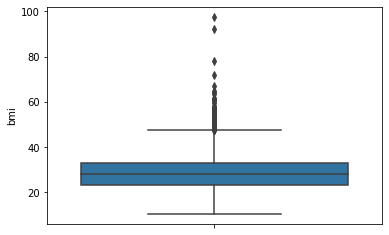

In [7]:
sns.boxplot(data=df,y="bmi",hue="stroke")

In [8]:
def outliers (df_out,drop=False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.round(np.percentile(feature_data,25),2)
        Q3 = np.round(np.percentile(feature_data,75),2)
        IQR = np.round(Q3-Q1,2)
        outlier_step = np.round(IQR * 1.5,2)
        print("Max",np.max(feature_data),"Min",np.min(feature_data),"Mean",np.round(np.mean(feature_data),2))
        print("IQR: ",IQR,"Q1: ",Q1,"down board",Q1-outlier_step," Q3: ",Q3,"upper board",Q3+outlier_step)
        outliers = feature_data[~((feature_data >= Q1 - outlier_step)&(feature_data <= Q3 + outlier_step))].index.tolist()
        print('For the feature {}, No of Outliers is {}'.format(each_feature,len(outliers)))


full_bmi = df[~df.bmi.isnull()]
outliers(full_bmi[["bmi"]])

Max 97.6 Min 10.3 Mean 28.89
IQR:  9.6 Q1:  23.5 down board 9.1  Q3:  33.1 upper board 47.5
For the feature bmi, No of Outliers is 110


In [9]:
# But BMI<14 it is not good. We can eliminate these.
a = df.stroke.value_counts().values[1]
print("When the BMI<14: \n",df[df.bmi<14].stroke.value_counts())
df = df[~(df.bmi<14)]
print("When the BMI>49: \n",df[df.bmi>49].stroke.value_counts())
df = df[~(df.bmi>49)]
b = df.stroke.value_counts().values[1]
print("We lost {} target number".format(a-b))

When the BMI<14: 
 0    16
Name: stroke, dtype: int64
When the BMI>49: 
 0    89
1     1
Name: stroke, dtype: int64
We lost 1 target number


In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
  
    return cat_cols, num_cols, cat_but_car
###
cat_cols, num_cols, cat_but_car = grab_col_names(df)
target = "stroke"

In [11]:
# Another preprocessing method find to very rare variable end eliminate.

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        a = np.min((dataframe[col].value_counts() / len(dataframe)))
        if a < 0.01: #Rare variable can be little than 1%
            print(col, ":", len(dataframe[col].value_counts()))
            print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                                "RATIO": dataframe[col].value_counts() / len(dataframe),
                                "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
        else:
            print(col," have'nt rare variable")
            
rare_analyser(df, target, cat_cols)

gender : 3
        COUNT     RATIO  TARGET_MEAN
Female   2918  0.583133     0.047978
Male     2085  0.416667     0.051799
Other       1  0.000200     0.000000


ever_married  have'nt rare variable
work_type : 5
               COUNT     RATIO  TARGET_MEAN
Govt_job         644  0.128697     0.051242
Never_worked      22  0.004396     0.000000
Private         2861  0.571743     0.051730
Self-employed    804  0.160671     0.080846
children         673  0.134492     0.002972


Residence_type  have'nt rare variable
smoking_status  have'nt rare variable
hypertension  have'nt rare variable
heart_disease  have'nt rare variable
stroke  have'nt rare variable


### BTW, I respect everyone's gender preference, but this creates noise in the dataset, I find it more appropriate to remove it from the dataset instead of changing its gender by assigning mode or median to it.

![ally](https://media.dayoftheshirt.com/images/shirts/wzWkW/teepublic_we-are-all-human-lgbt-gay-rights-pride-ally-gift-t-shirt-teepublic_1559101486.large.png)

#### And I will remove Never_worked variable in the work_type


In [12]:
print("Children but stroke patient:\n",(df[df.work_type=="children"].stroke.value_counts()))

Children but stroke patient:
 0    671
1      2
Name: stroke, dtype: int64


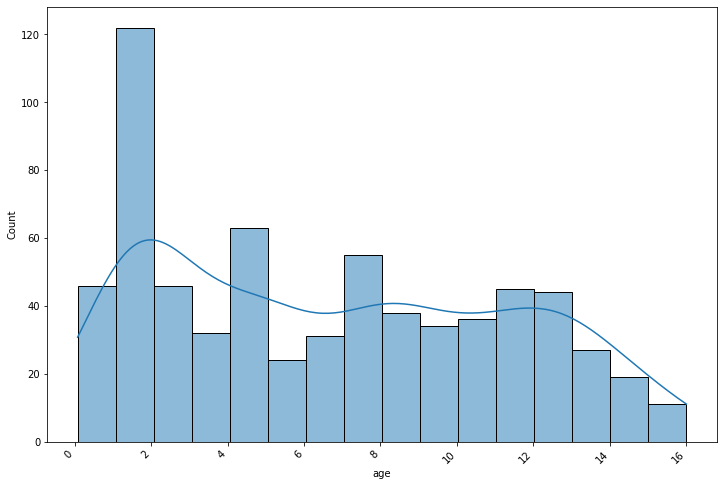

In [13]:
plt.figure(figsize=(12,8))
sns.histplot(df[df.work_type=="children"].age,
             bins=int(df[df.work_type=="children"].age.max()),
             kde=True,fill=True)
plt.xticks(rotation=45, ha='right')
plt.show()

# I assumed this variable mean that, they are children and they are doesnt work. 

<AxesSubplot:xlabel='smoking_status', ylabel='count'>

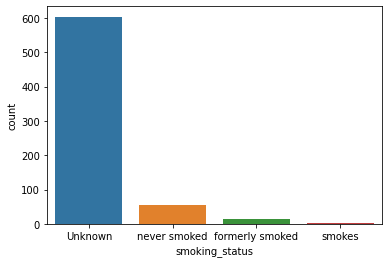

In [14]:
sns.countplot(data = df[df.work_type=="children"],
              x="smoking_status")
# what is the Formerly smoked children?

In [15]:
a = df.stroke.value_counts().values[1]
df = df[~(df.work_type=="Never_worked")]
df = df[~(df.gender=="Other")]
#df = df[~(df.work_type=="children")] - I tried but model doesnt work properly
b = df.stroke.value_counts().values[1]
print("We lost {} target number".format(a-b))
df.shape

We lost 0 target number


(4981, 11)

### There are also good integration, but we are doing obsessively integration for today.

In [16]:
#df["bmi"] = df.groupby(['gender','heart_disease',"hypertension","stroke",
#                        "ever_married","work_type","Residence_type","smoking_status"], 
#                       sort=False)['bmi'].apply(lambda x: x.fillna(x.mean(skipna=True)))

#df["bmi"] = df["bmi"].fillna(df.groupby(['gender','heart_disease',"hypertension","stroke",
#                        "ever_married","work_type","Residence_type","smoking_status"], 
#                       sort=False)['bmi'].transform("mean"))

In [17]:
# Selecting non NaN bmi values from df

X = df[~df.bmi.isnull()].drop(columns="bmi")
y = df[~df.bmi.isnull()].bmi
print(X.shape,y.shape)

(4780, 10) (4780,)


In [18]:
#X = pd.get_dummies(data=X,columns=['gender', 'hypertension', 'heart_disease', 'ever_married', 
#               'work_type', 'Residence_type', 'smoking_status', 'stroke'],drop_first=True)

print("Final X shape",X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
train = X_train.copy()
train["bmi"] = y_train
test = X_test.copy()
test["bmi"] = y_test
train.head()

Final X shape (4780, 10)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,bmi
123,Male,56.0,1,0,Yes,Private,Rural,249.31,never smoked,1,35.8
2657,Female,36.0,0,0,Yes,Govt_job,Rural,129.43,never smoked,0,29.7
4274,Female,36.0,0,0,Yes,Self-employed,Urban,202.06,never smoked,0,24.4
568,Female,81.0,0,0,No,Self-employed,Urban,71.91,Unknown,0,19.2
2251,Male,49.0,0,0,Yes,Private,Urban,130.07,never smoked,0,26.0


In [19]:
#!pip install --use-deprecated=legacy-resolver pycaret[full] --ignore-installed llvmlite
#!pip install markupsafe==2.0.1
#!pip install numba==0.53 --ignore-installed llvmlite

In [20]:
# After the install you will take error message, please Restart and run above
#from pycaret.regression import *

In [21]:
#reg1 = setup(train, 
#             target = 'bmi')

In [22]:
#best_specific = compare_models()

compare_models function

<a href="https://ibb.co/C91MdKD"><img src="https://i.ibb.co/1XvdVGj/Ekran-Resmi-2022-07-15-22-32-01.png" alt="Ekran-Resmi-2022-07-15-22-32-01" border="0"></a>

In [23]:
#gbr = create_model('gbr', verbose = True)

In [24]:
#tuned_gbr = tune_model(gbr,
#                       search_library='optuna', 
#                       search_algorithm='tpe',
#                       n_iter = 20)

In [25]:
#cb = create_model('catboost', verbose = True)

In [26]:
#tuned_cb = tune_model(cb,
#                       search_library='optuna', 
#                       search_algorithm='tpe',
#                       n_iter = 20)

In [27]:
#lightgbm = create_model('lightgbm', verbose = True)

In [28]:
#tuned_lightgbm = tune_model(lightgbm, tune_model(gbr,
#                       search_library='optuna', 
#                       search_algorithm='tpe',
#                       n_iter = 20)

In [29]:
#xgboost = create_model('xgboost', verbose = True)

In [30]:
#tuned_xgboost = tune_model(xgboost, tune_model(gbr,
#                       search_library='optuna', 
#                       search_algorithm='tpe',
#                       n_iter = 20)

In [31]:
#blender = blend_models(estimator_list = [tuned_gbr,
#                                         tuned_lightgbm,
#                                         tuned_cb,
#                                         tuned_xgboost],
#                      fold = 10,
#                      choose_better = False,
#                      optimize = "R2")

![](https://i.ibb.co/gdvZbGJ/Ekran-Resmi-2022-07-15-22-41-50.png)

In [32]:
#test.head()

In [33]:
#pred_unseen = predict_model(tuned_gbr, data = test.drop(columns="bmi"))

In [34]:
# Back to real issue
#print("R_sqr: ",r2_score(y_test, pred_unseen["Label"]))
#print("MSE: ",(mean_squared_error(y_test,pred_unseen["Label"]))) 

# For validation prediction

## R_sqr:  0.3035774217245104
## MSE:  32.602425936538175

### My best result ever yeah!!!

In [35]:
#evaluate_model(tuned_cb)

In [36]:
# Back real issue
#predict_bmi = df[df.bmi.isnull()].drop(columns="bmi")
#pred_unseen = predict_model(tuned_gbr, data = predict_bmi)

In [37]:
# I dont use id column again.
# I changed columns location like as original dataset
# pred_unseen["bmi"] = pred_unseen["Label"]
# pred_unseen = pred_unseen[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
#       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
#       'smoking_status', 'stroke']].reset_index().drop(columns="index")
#pred_unseen.head()

In [38]:
#Please check the full filled dataset!
new_dataset = pd.read_csv("../input/full-filled-brain-stroke-dataset/full_filled_stroke_data (1).csv")
new_dataset.bmi = new_dataset.bmi.apply(lambda x:np.round(x,1))
new_dataset.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,31.6,never smoked,1
1,Female,59.0,0,0,Yes,Private,Rural,76.15,30.2,Unknown,1
2,Male,78.0,0,1,Yes,Private,Urban,219.84,30.7,Unknown,1
3,Male,57.0,0,1,No,Govt_job,Urban,217.08,33.8,Unknown,1
4,Male,58.0,0,0,Yes,Private,Rural,189.84,31.4,Unknown,1


In [39]:
new_dataset

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,31.6,never smoked,1
1,Female,59.0,0,0,Yes,Private,Rural,76.15,30.2,Unknown,1
2,Male,78.0,0,1,Yes,Private,Urban,219.84,30.7,Unknown,1
3,Male,57.0,0,1,No,Govt_job,Urban,217.08,33.8,Unknown,1
4,Male,58.0,0,0,Yes,Private,Rural,189.84,31.4,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
196,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
197,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
198,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
199,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


In [40]:
#Let's concatenate to dataframes

X["bmi"] = y
X = X [['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke']].reset_index(drop="index")
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [41]:
dataset = pd.concat([X,new_dataset]).reset_index(drop="index")
print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB
None


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [42]:
dataset.to_csv("/kaggle/working/full_data.csv",index=False , header = 1)

![](https://ftw.usatoday.com/wp-content/uploads/sites/90/2017/02/shaq.jpg?w=1024&h=576&crop=1)